# [Challenge Data - Electricity price forecasting by Elmy](https://challengedata.ens.fr/challenges/140)

Ce notebook détaille la construction du benchmark de ce challenge - il peut également être utile aux participants pour se lancer dans la compétition. 

## Librairies

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## Chargement des données

- `X_train` et `X_test` ont  $10$ colonnes qui représentent les même variables explicatives mais sur des périodes de temps différentes il y a au plus $10 604$ lignes. 

- `X_train` et `Y_train` partagent la même colonne `DELIVERY_START` - chaque ligne a un DELIVERY_START unique associé à une date et heure de livraison de l'électricité
. 

- La variable cible `spot_id_delta` de `Y_train` correspond à l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

- **On notera que certaines colonnes ont des valeurs manquantes**.


In [5]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('data/X_train.csv')
Y_train = pd.read_csv('data/y_train.csv')
X_test = pd.read_csv('data/X_test.csv')

In [6]:
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [7]:
X_train.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,9318.000000,10604.000000,10604.000000,10604.000000,10581.000000,10581.000000,10581.000000,10581.000000,1846.000000
mean,53725.132968,2819.781592,11463.220671,35393.282252,4512.989415,1919.281353,125.399422,24.997384,140.256024
std,11274.194929,495.103588,483.799154,7619.820162,3349.419356,2706.963383,132.152875,43.083977,33.922669
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45336.500000,2226.000000,11140.000000,29005.000000,2036.000000,0.000000,46.818974,0.000000,119.405000
50%,51846.000000,2806.000000,11487.000000,32470.000000,3319.000000,149.000000,86.700163,3.507229,140.040000
75%,62091.750000,3386.000000,11945.000000,43055.000000,5951.000000,3507.000000,155.325644,35.137019,160.765000
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000


In [8]:
Y_train.head()

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907


In [9]:
Y_train.describe()

,spot_id_delta
count,10605.000000
mean,0.943358
std,38.093819
min,-1567.353547
25%,-11.934152
50%,0.059125
75%,12.190489
max,658.961329


In [10]:
Y_train_clean = Y_train['spot_id_delta']
Y_train_clean.head()

0   -36.874770
1   -12.643588
2    -1.950193
3     1.938272
4     0.199907
Name: spot_id_delta, dtype: float64

## Modèles et score d'entrainement

Le benchmark pour ce challenge consiste en une simple régression linéaire, après un léger nettoyage des données : Les valeurs manquantes (NaN) ont été remplacées par des zéros et la colonne `DELIVERY_START` a été supprimée 

In [11]:
lr = LinearRegression()

X_train_clean = X_train.drop(['DELIVERY_START'], axis=1).fillna(0)
Y_train_clean = Y_train['spot_id_delta']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print("Corrélation (Spearman) pour les données d'entrainement : {:.1f}%".format(100 * metric_train(output_train) ))



Corrélation (Spearman) pour les données d'entrainement : 10.3%


La corrélation de Spearman obtenue avec notre modèle sur les données d'entrainement est d'environ 10.3%.

NB : Les variations du prix de l'électricité peuvent être très volatiles et c'est pour cette raison que nous avons préféré la corrélation de Spearman à la corrélation usuelle (Pearson), pour avoir une fonction de score plus robuste.

## Générer le benchmark

Pour générer le benchmark on procède comme on l'a fait avec les données d'entrainement mais cette fois sur les données test, et on renvoie la sortie au format csv adapté aux contraintes des sorties du challenge.  


In [12]:
X_test.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2023-04-02 00:00:00+02:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0,NaN
1,2023-04-02 01:00:00+02:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0,NaN
2,2023-04-02 02:00:00+02:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0,NaN
3,2023-04-02 03:00:00+02:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0,NaN
4,2023-04-02 04:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0,NaN


In [13]:
Y_train_clean.head()

0   -36.874770
1   -12.643588
2    -1.950193
3     1.938272
4     0.199907
Name: spot_id_delta, dtype: float64

In [14]:
X_test_clean = X_test.drop(['DELIVERY_START'], axis=1).fillna(0)

Y_test_submission = X_test[['DELIVERY_START']].copy()
Y_test_submission['spot_id_delta'] = lr.predict(X_test_clean)

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


On soumet alors le fichier benchmark_qrt.csv sur le site du challenge https://challengedata.ens.fr, et on obtient alors une corrélation d'environ 55.26 % sur le site


In [ ]:
X_train_clean.describe()

On a 10605 données


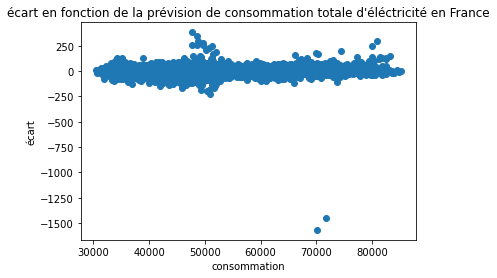

In [17]:
y=Y_train["spot_id_delta"]
x=X_train["load_forecast"]
plt.title("écart en fonction de la prévision de consommation totale d'éléctricité en France")
plt.xlabel("consommation")
plt.ylabel("écart")
plt.scatter(x,y)

In [15]:
df = pd.merge(X_train, Y_train, on='DELIVERY_START', how='inner')
df.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,-36.874770
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN,-12.643588
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN,-1.950193
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN,1.938272
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN,0.199907


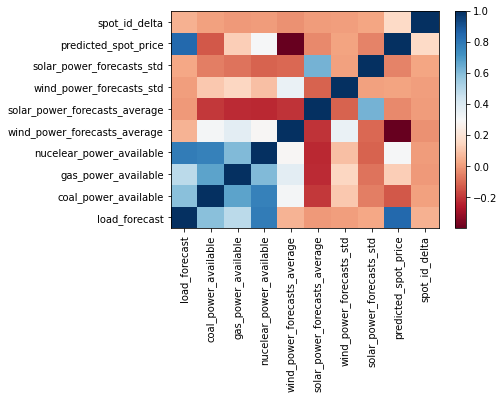

In [16]:
tab=df.corr()
fig, ax = plt.subplots()
im = ax.pcolor(tab, cmap='RdBu')
row_labels = tab.columns
col_labels = tab.index
ax.set_xticks(np.arange(tab.shape[1])+0.5, minor= False)
ax.set_yticks(np.arange(tab.shape[0])+0.5, minor= False)
ax.set_xticklabels(row_labels, minor = False)
ax.set_yticklabels(col_labels, minor = False)
plt.xticks(rotation=90)
fig.colorbar(im)
plt.show()